**Предсказание стоимости жилья**

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

**Описание данных**
-	`longitude` — широта;
-	`latitude` — долгота;
-	`housing_median_age` — медианный возраст жителей жилого массива;
-	`total_rooms` — общее количество комнат в домах жилого массива;
-	`total_bedrooms` — общее количество спален в домах жилого массива;
-	`population` — количество человек, которые проживают в жилом массиве;
-	`households` — количество домовладений в жилом массиве;
-	`median_income` — медианный доход жителей жилого массива;
-	`median_house_value` — медианная стоимость дома в жилом массиве;
-	`ocean_proximity` — близость к океану.


## Подготовка данных

In [1]:
#Необходимые импорты
import pandas as pd 
import numpy as np

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
#from pyspark.ml.classification import LogisticRegression
#from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
#pyspark_version = pyspark.__version__
#if int(pyspark_version[:1]) == 3:
#    from pyspark.ml.feature import OneHotEncoder    
#elif int(pyspark_version[:1]) == 2:
#    from pyspark.ml.feature import OneHotEncodeEstimator
from pyspark.ml.feature import OneHotEncoder
        
RANDOM_SEED = 543


In [2]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("ML California Housing") \
                    .getOrCreate()

In [ ]:

if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder as OHE
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator as OHE


In [3]:
#Загрузка данных
df = spark.read.load('/datasets/housing.csv', format="csv", sep=",", inferSchema=True, header="true")
#Вывод информации о типах данных
df.printSchema()
#df.show(5)


root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [4]:
#Оценка количества пропусков
columns = df.columns
for column in columns:
    check_col = (F.col(column).isNull() | F.isnan(F.col(column)))
    print(column, df.filter(check_col).count())


longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


In [5]:
#Заполнение пропусков медианой
total_bedrooms_median = int(df.approxQuantile('total_bedrooms', [0.5], 0)[0])
#print (total_bedrooms_median)
df=df.na.fill(value=total_bedrooms_median,subset=["total_bedrooms"])

#проверим
print('К-во провусков в total_bedrooms  ', df.filter(df['total_bedrooms'].isNull()).count())

К-во провусков в total_bedrooms   0


In [6]:
df.describe().toPandas().transpose() 

,0,1,2,3,4
summary,count,mean,stddev,min,max
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,39320.0
total_bedrooms,20640,536.8388565891473,419.39187792168866,1.0,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,15.0001
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,500001.0


In [7]:
#удалим колонки координат как бесползные для данной задачи
exclude = ['longitude', 'latitude']
df = df.drop(*exclude)
df.printSchema()

root
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = false)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



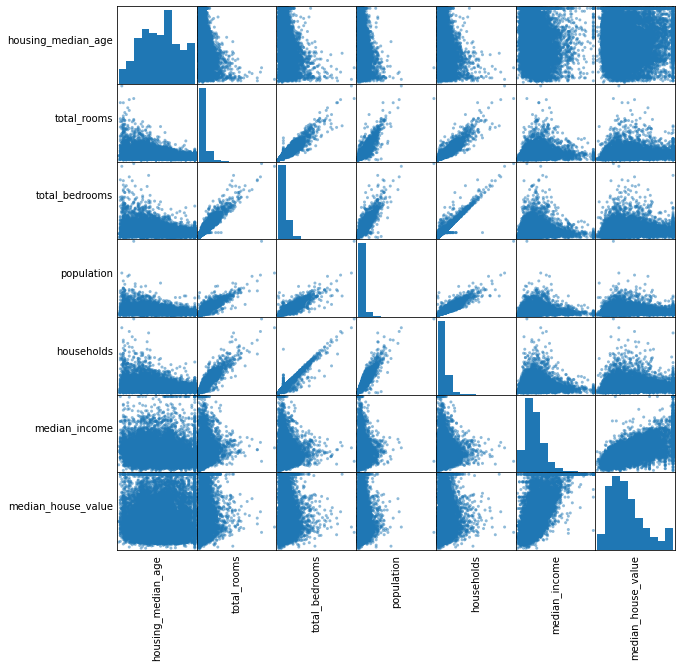

In [8]:
# Визуализация характера связей
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [9]:
#расчет новых признаков  (из тренировойного задания)
df = df.withColumn('rooms_per_household', F.col('total_rooms') / F.col('households'))
df = df.withColumn('population_in_household', F.col('population') / F.col('households'))
df = df.withColumn('bedroom_index', F.col('total_bedrooms') / F.col('total_rooms'))
df.printSchema()


root
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = false)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- rooms_per_household: double (nullable = true)
 |-- population_in_household: double (nullable = true)
 |-- bedroom_index: double (nullable = true)



In [10]:
#рассчитаем коэфф. кор. Пирсона
import six
for i in df.columns:
    if not( isinstance(df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to target for ", i, df.stat.corr('median_house_value',i))

Correlation to target for  housing_median_age 0.10562341249321067
Correlation to target for  total_rooms 0.13415311380656275
Correlation to target for  total_bedrooms 0.049456861920854314
Correlation to target for  population -0.024649678888894876
Correlation to target for  households 0.06584265057005637
Correlation to target for  median_income 0.6880752079585578
Correlation to target for  median_house_value 1.0
Correlation to target for  rooms_per_household 0.15194828974146016
Correlation to target for  population_in_household -0.023737412956134192
Correlation to target for  bedroom_index -0.23330292651593865


Выраженные корреляции кроме как с median_income отсутствуют

In [11]:
#заготовим датасет без кат признака
df_num =df.drop('ocean_proximity') 
df_num.printSchema()

root
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = false)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- rooms_per_household: double (nullable = true)
 |-- population_in_household: double (nullable = true)
 |-- bedroom_index: double (nullable = true)



In [12]:
#соберем списки категориальных, числовых значений и определим таргет.
cat_col = ['ocean_proximity']
num_col = [col for col in df.columns if col not in cat_col]
#Убираем таргет
num_col.remove('median_house_value')
print (num_col)
#target
target = 'median_house_value'

['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'population_in_household', 'bedroom_index']


In [13]:
#Разделение на выборки в соотношении 80% 20%
train_data_all, test_data_all =df.randomSplit([.8,.2], seed=RANDOM_SEED)
#rint(train_data_all.count(), test_data_all.count()) 

In [14]:
#обучение трансформеров на трейне и раздельное кодирование выборок.
#Обработка категориальных
indexer = StringIndexer(inputCols=cat_col, outputCols=[c+'_idx' for c in cat_col]) 
indexer = indexer.fit(train_data_all)
train_data_all = indexer.transform(train_data_all)
test_data_all = indexer.transform(test_data_all)

encoder = OneHotEncoder(inputCols=[c+'_idx' for c in cat_col],
                        outputCols=[c+'_ohe' for c in cat_col])

encoder = encoder.fit(train_data_all)
train_data_all = encoder.transform(train_data_all)
test_data_all = encoder.transform(test_data_all)
#Преобразование категориальных в один вектор
categorical_assembler = VectorAssembler(inputCols=[c+'_ohe' for c in cat_col],
                                        outputCol="categorical_features")
train_data_all = categorical_assembler.transform(train_data_all)
test_data_all = categorical_assembler.transform(test_data_all)
#Трансформация числовых признаков
numerical_assembler = VectorAssembler(inputCols=num_col, outputCol="numerical_features") 
train_data_all = numerical_assembler.transform(train_data_all)
test_data_all = numerical_assembler.transform(test_data_all)

standardScaler = StandardScaler(inputCol='numerical_features', outputCol="numerical_features_scaled")
standardScaler = standardScaler.fit(train_data_all)
train_data_all = standardScaler.transform(train_data_all)
test_data_all = standardScaler.transform(test_data_all)
#сборка трансформированных признаков в один вектор
all_features = ['categorical_features','numerical_features_scaled']
final_assembler = VectorAssembler(inputCols=all_features, outputCol="all_features") 
train_data_all = final_assembler.transform(train_data_all)
test_data_all = final_assembler.transform(test_data_all) 

# проверим.
test_data_all.select('all_features', 'numerical_features_scaled', 'median_house_value').show(3)
test_data_all.select('all_features', 'numerical_features_scaled','median_house_value' ).show(3)   

+--------------------+-------------------------+------------------+
|        all_features|numerical_features_scaled|median_house_value|
+--------------------+-------------------------+------------------+
|[0.0,1.0,0.0,0.0,...|     [0.07954269499686...|          141700.0|
|[0.0,1.0,0.0,0.0,...|     [0.07954269499686...|          189200.0|
|[1.0,0.0,0.0,0.0,...|     [0.15908538999373...|          500001.0|
+--------------------+-------------------------+------------------+
only showing top 3 rows

+--------------------+-------------------------+------------------+
|        all_features|numerical_features_scaled|median_house_value|
+--------------------+-------------------------+------------------+
|[0.0,1.0,0.0,0.0,...|     [0.07954269499686...|          141700.0|
|[0.0,1.0,0.0,0.0,...|     [0.07954269499686...|          189200.0|
|[1.0,0.0,0.0,0.0,...|     [0.15908538999373...|          500001.0|
+--------------------+-------------------------+------------------+
only showing top 3 rows

## Обучение моделей

In [15]:
#обучим модель model_all_futures по всем признакам
lr = LinearRegression( featuresCol='all_features', labelCol=target)
model_all_futures = lr.fit(train_data_all) 

24/05/24 15:19:08 WARN Instrumentation: [995e8c21] regParam is zero, which might cause numerical instability and overfitting.
24/05/24 15:19:08 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/05/24 15:19:08 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
24/05/24 15:19:09 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/05/24 15:19:09 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [16]:
#обучим модель model_num без категориального признака
lr = LinearRegression(labelCol=target, featuresCol='numerical_features_scaled')
model_num = lr.fit(train_data_all) 

24/05/24 15:19:11 WARN Instrumentation: [03046004] regParam is zero, which might cause numerical instability and overfitting.


## Анализ результатов

In [17]:
#Тестируем модель со всеми признаками
lr_predictions_all_futures = model_all_futures.transform(test_data_all)
lr_predictions_all_futures.select("prediction",target,"all_features").show(5)

+------------------+------------------+--------------------+
|        prediction|median_house_value|        all_features|
+------------------+------------------+--------------------+
|154351.55305235353|          141700.0|[0.0,1.0,0.0,0.0,...|
|150035.40616715123|          189200.0|[0.0,1.0,0.0,0.0,...|
|364658.51182258653|          500001.0|[1.0,0.0,0.0,0.0,...|
|239671.77996857898|          158500.0|[0.0,0.0,1.0,0.0,...|
|240019.65123852307|          329500.0|[0.0,1.0,0.0,0.0,...|
+------------------+------------------+--------------------+
only showing top 5 rows



In [18]:
#Получим метрики для модели на основе всех признаков
print ('Метрики для модели основанной на всех признаках')
print ('Метрика R2 : ',  RegressionEvaluator(labelCol='median_house_value',
                         metricName='r2').evaluate(lr_predictions_all_futures))
print ('Метрика RMSE : ',RegressionEvaluator(labelCol='median_house_value',
                         metricName='rmse').evaluate(lr_predictions_all_futures))
print ('Метрика MAE : ', RegressionEvaluator(labelCol='median_house_value',
                         metricName='mae').evaluate(lr_predictions_all_futures))

Метрики для модели основанной на всех признаках
Метрика R2 :  0.6437029512559611
Метрика RMSE :  69200.0227552419
Метрика MAE :  49229.44852318738


In [19]:
#Тестируем модель только с num признаками
lr_predictions_num = model_num.transform(test_data_all)
lr_predictions_num.select("prediction",target,"numerical_features_scaled").show(5)
#lr_evaluator = RegressionEvaluator(predictionCol="prediction",  labelCol=target, metricName="r2")
#print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+------------------+-------------------------+
|        prediction|median_house_value|numerical_features_scaled|
+------------------+------------------+-------------------------+
|186082.32293063268|          141700.0|     [0.07954269499686...|
|140333.98185547913|          189200.0|     [0.07954269499686...|
| 343861.7399064058|          500001.0|     [0.15908538999373...|
| 192454.7904229408|          158500.0|     [0.15908538999373...|
|265154.67042080575|          329500.0|     [0.15908538999373...|
+------------------+------------------+-------------------------+
only showing top 5 rows



In [20]:
#Получим метрики для модели на основе числовых признаков
print ('Метрики для модели основанной на числовых признаках')
print ('Метрика R2: ',   RegressionEvaluator(labelCol='median_house_value',
                         metricName='r2').evaluate(lr_predictions_num))
print ('Метрика RMSE: ', RegressionEvaluator(labelCol='median_house_value',
                         metricName='rmse').evaluate(lr_predictions_num))
print ('Метрика MAE : ', RegressionEvaluator(labelCol='median_house_value',
                         metricName='mae').evaluate(lr_predictions_num))

Метрики для модели основанной на числовых признаках
Метрика R2:  0.5865840753457352
Метрика RMSE:  74540.74439668555
Метрика MAE :  53996.72778421933


In [21]:
spark.stop()

**Заключение**:
Обработаны обнаруженные пропуски в данных. Проведен анализ взаимосвязей признаков. Сравнены модели линейной регрессии. 
Качество моделей линейной регрессии основанной на всех признаках превысило качество модели с исключением категориального признака. Метрики R2 0.64 и 0.58  MAE 49229.44 и 53996.72 соответственно.  

<font color='green'>Немного полезного материала:
+  https://sparkbyexamples.com/pyspark-tutorial/, https://sparkbyexamples.com/
+  https://github.com/dvgodoy/handyspark
+  https://www.tutorialspoint.com/pyspark/index.htm
+  https://www.guru99.com/pyspark-tutorial.html
+  https://databricks.com/spark/getting-started-with-apache-spark/machine-learning#load-sample-data
</font>